In [1]:
import torch as t 
import torchvision
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pylab as plt
from torch.nn.utils import clip_grad_value_
%matplotlib inline
import pickle
from torchvision import datasets, transforms
import tqdm
import os
import sys
sys.path.append('../src/')

In [7]:
import importlib 
import kernel_hypernet as kernel_hypernet
import var_net as var_net
import mnist_utils as utils
importlib.reload(utils)
importlib.reload(var_net)
importlib.reload(kernel_hypernet)



<module 'kernel_hypernet' from '../src/kernel_hypernet.py'>

In [3]:
device = 'cuda' # cuda or cpu
device = t.device(device)
if device == 'cuda':
    t.backends.cudnn.deterministic = True
    t.backends.cudnn.benchmark = False

In [4]:
batch_size = 256
init_log_sigma = -3.0 # логарифм дисперсии вариационного распределения при инициализации
prior_sigma = .1 # априорная дисперсия
epoch_num = 25 #количество эпох
lamb = [0.01, 0.1, 1.0,  10.0, 100.0]
lamb = [t.tensor(l) for l in lamb]
hidden_num = 50 # количество нейронов на скрытом слое
acc_delete = [] 
start_num = 5
path_to_save = 'saved_mnist'
lambda_sample_num = 5
lambda_encode = t.log 

if not os.path.exists(path_to_save):
    os.mkdir(path_to_save)

In [5]:
# загрузка данных
train_data = torchvision.datasets.MNIST('./files/', train=True, download=True,
                             transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                                  torchvision.transforms.Lambda(lambda x: x.view(-1))
                              ]))

test_data = torchvision.datasets.MNIST('./files/', train=False, download=True,
                             transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                                  torchvision.transforms.Lambda(lambda x: x.view(-1))
                              ]))


train_loader = t.utils.data.DataLoader(train_data, batch_size=batch_size, pin_memory=True )
test_loader = t.utils.data.DataLoader(test_data, batch_size=batch_size)





In [32]:
# предварительный подбор количества ядер

importlib.reload(kernel_hypernet)
kernel_num = 50
t.manual_seed(0)

                 
net = var_net.VarNet(kernel_hypernet.VarKernelLayer(784,  hidden_num, kernel_num, prior_sigma=prior_sigma, init_log_sigma=init_log_sigma),
             kernel_hypernet.VarKernelLayer(hidden_num, 10,   kernel_num, 
                                                prior_sigma=prior_sigma, act=lambda x:x, init_log_sigma=init_log_sigma))

net = net.to(device)
optim = t.optim.Adam(net.parameters(), lr=5e-4)
loss_fn = nn.CrossEntropyLoss().to(device)            
for e in range(3):
    label = 'epoch {}: '.format(e)                
    utils.train_batches_hypernet(train_loader,  len(train_data), lambda_sample_num,
          lambda_encode, net, device, loss_fn, optim, label)

print (utils.test_acc_hyper(net, device, test_loader, lambda_encode, lamb))

#1: loss=5.05,acc=0.85/0.85/0.85/0.850+0.85
#10: loss=0.58, acc=0.89/0.89/0.88/0.88/0.87
# 20: loss=0.53
# 15: loss=0.55
# 5: loss=0.71, acc=0.87,0.88,0.87,0.87,0.87
#7: loss=0.0.62, acc=...
# возьмем 20

epoch 2: 0.49396268: 100%|██████████| 235/235 [00:27<00:00,  8.62it/s]


{tensor(0.0100): 0.8929, tensor(0.1000): 0.8966, tensor(1.): 0.8897, tensor(10.): 0.8694, tensor(100.): 0.8387}


In [ ]:
t.manual_seed(0)
kernel_num = 20
for start in range(start_num):                    
        net = var_net.VarNet(kernel_hypernet.VarKernelLayer(784,  hidden_num, kernel_num, prior_sigma=prior_sigma, init_log_sigma=init_log_sigma),
             kernel_hypernet.VarKernelLayer(hidden_num, 10,   kernel_num, 
                                                prior_sigma=prior_sigma, act=lambda x:x, init_log_sigma=init_log_sigma))

        net = net.to(device)
        optim = t.optim.Adam(net.parameters(), lr=5e-4)
        loss_fn = nn.CrossEntropyLoss().to(device)            
        for e in range(epoch_num):
            label = 'epoch {}: '.format(e)                
            utils.train_batches_hypernet(train_loader,  len(train_data), lambda_sample_num,
                  lambda_encode, net, device, loss_fn, optim, label, rep=True)
            if e%5 == 0:
                print (utils.test_acc_hyper(net, device, test_loader, lambda_encode, lamb))
        t.save(net.state_dict(), os.path.join(path_to_save, 'rep_kernel_start_{}.cpk'.format(start)))

epoch 1: 0.75845385:   0%|          | 1/235 [00:00<00:44,  5.21it/s]

{tensor(0.0100): 0.7908, tensor(0.1000): 0.8197, tensor(1.): 0.8217, tensor(10.): 0.8279, tensor(100.): 0.8013}


epoch 6: 0.28050083:   0%|          | 1/235 [00:00<00:26,  8.90it/s]

{tensor(0.0100): 0.9302, tensor(0.1000): 0.9341, tensor(1.): 0.9282, tensor(10.): 0.9128, tensor(100.): 0.8541}


epoch 10: 0.25185186:  73%|███████▎  | 172/235 [00:25<00:10,  5.93it/s]

In [9]:
net = var_net.VarNet(var_net.VarLayer(784,  hidden_num, 
                                            prior_sigma = prior_sigma, init_log_sigma=init_log_sigma), 
                                 var_net.VarLayer(hidden_num, 10, prior_sigma=prior_sigma,  init_log_sigma=init_log_sigma,
                                          act=lambda x:x)).to(device)    
hnet =  var_net.VarNet(kernel_hypernet.VarKernelLayer(784,  hidden_num, kernel_num, prior_sigma=prior_sigma, init_log_sigma=init_log_sigma),
             kernel_hypernet.VarKernelLayer(hidden_num, 10,   kernel_num, 
                                                prior_sigma=prior_sigma, act=lambda x:x, init_log_sigma=init_log_sigma))

hnet = hnet.to(device)
net = net.to(device)
lam_results = {}
for lam in lamb:
    lam_results[lam] = []
    for s in range(start_num):        
        print (lam, s)
        hnet.load_state_dict(t.load(os.path.join(path_to_save, 'rep_kernel_start_{}.cpk'.format(s))))        
        utils.net_copy(hnet, net, lambda_encode(t.ones(1).to(device)[0]*lam))
        lam_results[lam].append(utils.delete_10(net, device, lambda:utils.test_acc_net(net, device, test_loader)))
lam_results = {float(k):lam_results[k] for k in lam_results}
import json
with open(os.path.join(path_to_save, 'results_rep_kernel.json'),'w') as out:
    out.write(json.dumps(lam_results))  

../src/var_net.py:9: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  t.nn.init.xavier_uniform(self.mean)


tensor(0.0100) 0
tensor(0.0100) 1
tensor(0.0100) 2
tensor(0.0100) 3
tensor(0.0100) 4
tensor(0.1000) 0
tensor(0.1000) 1
tensor(0.1000) 2
tensor(0.1000) 3
tensor(0.1000) 4
tensor(1.) 0
tensor(1.) 1
tensor(1.) 2
tensor(1.) 3
tensor(1.) 4
tensor(10.) 0
tensor(10.) 1
tensor(10.) 2
tensor(10.) 3
tensor(10.) 4
tensor(100.) 0
tensor(100.) 1
tensor(100.) 2
tensor(100.) 3
tensor(100.) 4


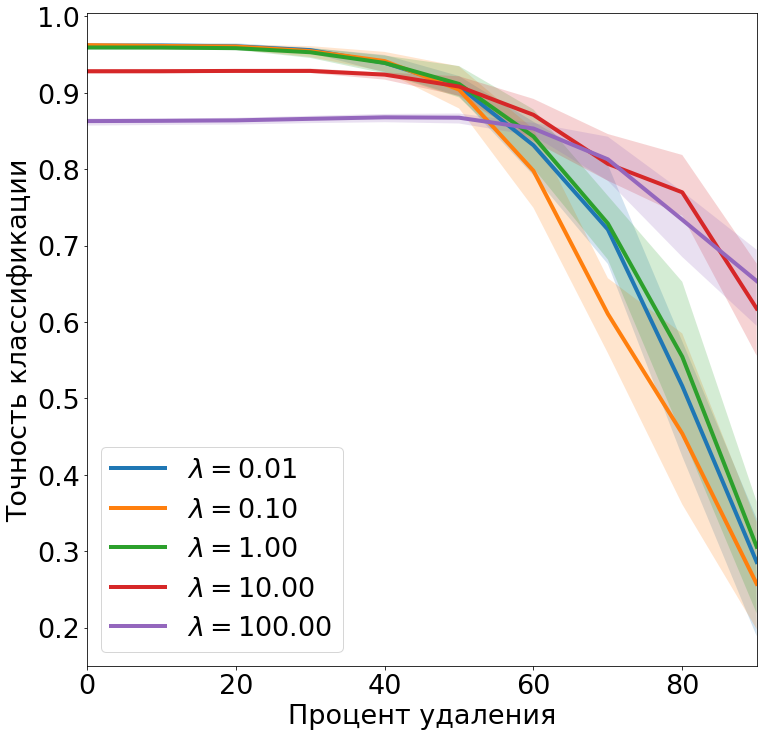

In [10]:
proc = [0,10,20,30,40,50,60,70,80,90]
plt.rcParams['figure.figsize'] = 12, 12
plt.rcParams.update({'font.size': 27})
plt.rc('lines', linewidth=4)
    
    
for lam in lamb:
    lam = float(lam)
    lam_str = "{:10.2f}".format(lam)

    plt.fill_between(proc, np.min(lam_results[lam], 0), np.max(lam_results[lam], 0), alpha=0.2)
    plt.plot(proc, np.mean(lam_results[lam], 0), label='$\lambda={}$'.format(lam_str))
plt.ylabel('Точность классификации', fontsize = 27)
plt.xlabel('Процент удаления', fontsize = 27)
plt.tick_params(axis='both', which='major', labelsize=27)
plt.legend(loc='lower left')
plt.autoscale(enable=True, axis='x', tight=True)
plt.savefig('Kernel_rep')
#plt.show()
